# Forecast

In [ ]:
# !pip install git+https://github.com/patricksferraz/pyaiutils.git@chore/requirements

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import pyaiutils as pai
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import pickle
import shap
import os

#### Variáveis

In [2]:
DATASET = 'downloads/pre-processed'
OUTPUT = 'downloads/results'

#### Funções

Função para verificar a existência do path, caso o caminho não exista, ele é criado
- path: caminho

In [3]:
def sync_path(path: str) -> None:
    lvs = path.split('/')
    for lv in range(1, len(lvs)+1):
        check = '/'.join(lvs[:lv])
        if not os.path.exists(check):
            os.mkdir(check)

Função para exibir o o histórico de treinamento

- history: history de treinamento

In [4]:
def show_history(path: str):
    with open(path, 'rb') as f:
        history = pickle.load(f)

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

    ax[0].set_ylabel('Categorical Crossentropy')
    ax[0].plot(range(len(history['loss'])), history['loss'], label='Train loss')
    ax[0].plot(range(len(history['loss'])), history['val_loss'], label='Validation loss')
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(range(len(history['loss'])), history['acc'], label='Train acc')
    ax[1].plot(range(len(history['loss'])), history['val_acc'], label='Validation acc')
    ax[1].legend()
    
    plt.show()

Metrics

In [5]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [7]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Função para avaliação do modelo
- model: modelo
- x_test: dataframe de entrada
- y_test: dataframe alvo
- class_names: classes
- path: caminho para armazenar os resultados

In [8]:
def evaluate(
    model: tf.keras.Sequential,
    x_test: np.ndarray,
    y_test: np.ndarray,
    class_names: [str],
    path: str
) -> None:
    y_pred = model.predict(x_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    pai.plot_graphics(y_true, y_pred, class_names=class_names, save_path=path)
    display(pai.get_metrics(y_true, y_pred, class_names=class_names, save_path=path))

## Classificação

Algoritmos de classificação

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

Métricas de avaliação

Matriz de Confusão | Recall vs Precision | Equação de 4 diferentes métricas
- | - | -
![](https://miro.medium.com/max/1400/1*N6I3pi0prhiJ_Y85HAx4wA.png) | ![](https://miro.medium.com/max/700/0*uhuG2rhX6XzNC43X.png) | ![](https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png)

### COVID/NÃO-COVID

Carregando dataframe:
- `f'{DATASET}/20-21.csv.gz'`

|Sintomas|Comorbidades|CS_SEXO|NU_IDADE_N|CLASSI_FIN|EVOLUCAO|
|--|--|--|--|--|--|
|1. Sim|1. Sim|F: Feminino||0. Não Covid|1. Cura|
|2. Não|2. Não|M: Masculino||1. Covid|2. Óbito|
|9. Ignorado|9. Ignorado|I: Ignorado|||9. Ignorado|


Delimitando as colunas de interesse

In [310]:
symptoms = [
    'FEBRE',
    'TOSSE',
    'GARGANTA',
    'DISPNEIA',
    'DESC_RESP',
    'SATURACAO',
    'DIARREIA',
]
comorbidities = [
    'PUERPERA',
    'CARDIOPATI',
    'SIND_DOWN',
    'HEPATICA',
    'NEUROLOGIC',
    'PNEUMOPATI',
    'IMUNODEPRE',
    'RENAL',
    'OBESIDADE',
]
interest_cols = [
    *symptoms,
    *comorbidities,
    'CS_SEXO',
    'NU_IDADE_N',
    'CLASSI_FIN',
]

Carregando os dados do OpenDataSUS

In [311]:
# df_ods = pd.read_csv(f'{DATASET}/ODS/covid-ncovid/09-20/09-20.csv.gz', low_memory=False, compression='gzip')
# df_ods

Carregando os dados do ISI

In [312]:
df_isi = pd.concat([
    pd.read_csv(f'{DATASET}/ISI/train_data/train_11.02.2021.csv', low_memory=False),
    pd.read_csv(f'{DATASET}/ISI/test_data/test_11.02.2021.csv', low_memory=False),
])
df_isi.columns = interest_cols
df_isi

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,PUERPERA,CARDIOPATI,SIND_DOWN,HEPATICA,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,CS_SEXO,NU_IDADE_N,CLASSI_FIN
0,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,47.0,0.0
1,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,35.0,0.0
2,2,2,1,2,2,0,1,0,2,2,2,2,2,2,2,2,2.0,39.0,0.0
3,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,26.0,0.0
4,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2,2,2,2,2,0,2,0,1,2,2,2,2,2,2,2,1.0,47.0,1.0
1530,1,1,1,2,2,0,2,0,1,2,2,2,2,2,2,2,1.0,37.0,1.0
1531,1,1,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,24.0,1.0
1532,2,2,2,2,2,0,2,0,1,2,2,2,2,2,2,2,2.0,46.0,1.0


In [313]:
# covid_ncovid = pd.concat([df_ods, df_isi])
# covid_ncovid

# covid_ncovid = df_ods.copy()
covid_ncovid = df_isi.copy()

Removendo features (alternativa)

In [314]:
# covid_ncovid = covid_ncovid.drop(columns=[
#     'PUERPERA',
#     'SATURACAO',
#     'SIND_DOWN',
#     'HEPATICA',
#     'NEUROLOGIC',
#     'OBESIDADE',
#     'CS_SEXO',
#     'IMUNODEPRE',
#     'RENAL'
# ])
# covid_ncovid

In [315]:
covid_ncovid['CLASSI_FIN'].value_counts()

0.0    9725
1.0     767
Name: CLASSI_FIN, dtype: int64

Listando as colunas existentes

In [316]:
covid_ncovid.columns

Index(['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO',
       'DIARREIA', 'PUERPERA', 'CARDIOPATI', 'SIND_DOWN', 'HEPATICA',
       'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE',
       'CS_SEXO', 'NU_IDADE_N', 'CLASSI_FIN'],
      dtype='object')

Colunas para estudo

In [317]:
# x_cols = [
#     *symptoms,
#     *comorbidities,
#     'CS_SEXO',
#     'NU_IDADE_N',
# ]
x_cols = covid_ncovid.columns[:-1]
y_cols = ['CLASSI_FIN']

Split dataset
- train 60
- test 20
- val 20

In [318]:
x_train, x_test, y_train, y_test = train_test_split(
    covid_ncovid[x_cols],
    covid_ncovid[y_cols],
    test_size=0.2,
    random_state=1
)

In [319]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.25,
    random_state=1
)

In [320]:
y_train['CLASSI_FIN'].value_counts()

0.0    5834
1.0     460
Name: CLASSI_FIN, dtype: int64

In [321]:
y_val['CLASSI_FIN'].value_counts()

0.0    1928
1.0     171
Name: CLASSI_FIN, dtype: int64

In [322]:
y_test['CLASSI_FIN'].value_counts()

0.0    1963
1.0     136
Name: CLASSI_FIN, dtype: int64

Normalizando os dados

In [323]:
x_scaler = MinMaxScaler((0,1))
y_scaler = MinMaxScaler((0,1))

x_train = x_scaler.fit_transform(x_train)
# y_train = y_scaler.fit_transform(y_train)

x_val = x_scaler.transform(x_val)
# y_val = y_scaler.transform(y_val)

x_test = x_scaler.transform(x_test)
# y_test = y_scaler.transform(y_test)

In [324]:
path_dfcovid = f'{DATASET}/ISI/transfer-learning'
path = f'{path_dfcovid}/mlp/allvariables'

mlp|cnn

In [325]:
pickle.dump(x_scaler, open(f'{path}/xscaler.pkl', 'wb'))
pickle.dump(y_scaler, open(f'{path}/yscaler.pkl', 'wb'))

In [326]:
pd.DataFrame(x_train, columns=x_cols).to_csv(f'{path}/xtrain.csv', index=False)
pd.DataFrame(y_train, columns=y_cols).to_csv(f'{path}/ytrain.csv', index=False)
pd.DataFrame(x_val, columns=x_cols).to_csv(f'{path}/xval.csv', index=False)
pd.DataFrame(y_val, columns=y_cols).to_csv(f'{path}/yval.csv', index=False)
pd.DataFrame(x_test, columns=x_cols).to_csv(f'{path}/xtest.csv', index=False)
pd.DataFrame(y_test, columns=y_cols).to_csv(f'{path}/ytest.csv', index=False)

Conversão para categorical (One Hot Encoding)

In [327]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [328]:
classes_target = ['N-Covid', 'Covid']
pd.DataFrame(y_train, columns=classes_target).to_csv(f'{path}/ytrain_cc.csv', index=False)
pd.DataFrame(y_val, columns=classes_target).to_csv(f'{path}/yval_cc.csv', index=False)
pd.DataFrame(y_test, columns=classes_target).to_csv(f'{path}/ytest_cc.csv', index=False)

#### RNA (MLP)

In [329]:
path_mlpcovid = f'{OUTPUT}/ISI/transfer-learning/covid-ncovid/mlp'
path = f'{path_mlpcovid}/allvariables'

Carregando modelo gerado

In [331]:
model = tf.keras.models.load_model(
#     f'{OUTPUT}/ODS/covid-ncovid/mlp/r_per_sat_down_hep_neu_obe_sex/deploy/model.h5',
    './models/mlp_covid.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                969       
_________________________________________________________________
dense_1 (Dense)              (None, 88)                4576      
_________________________________________________________________
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_3 (Dense)              (None, 51)                3927      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 104       
Total params: 16,340
Trainable params: 16,340
Non-trainable params: 0
___________________________________________________________

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                969       
_________________________________________________________________
dense_1 (Dense)              (None, 88)                4576      
_________________________________________________________________
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_3 (Dense)              (None, 51)                3927      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 104       
Total params: 16,340
Trainable params: 104
Non-trainable params: 16,236
_________________________________________________________

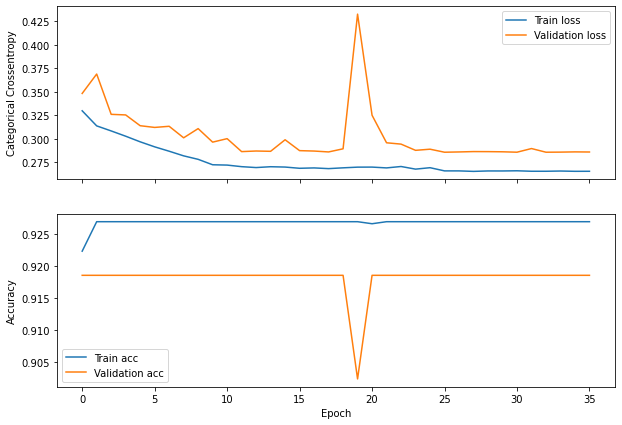

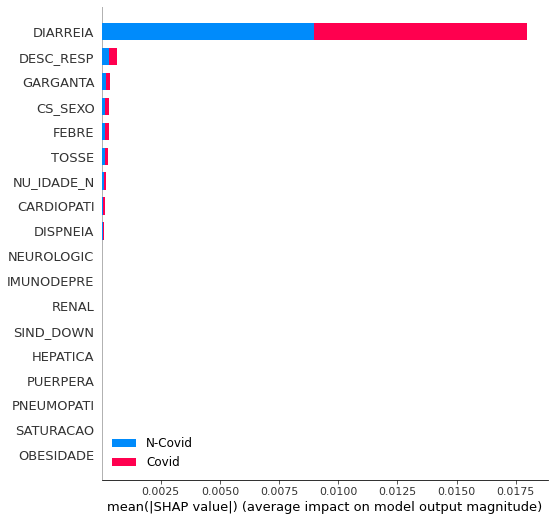

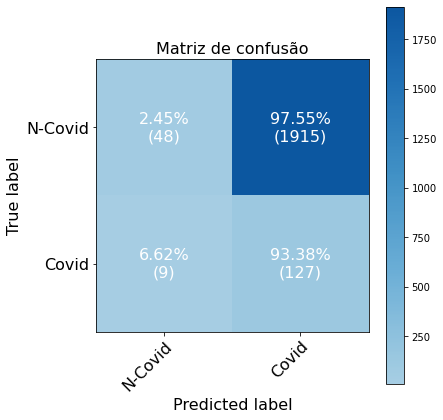

None

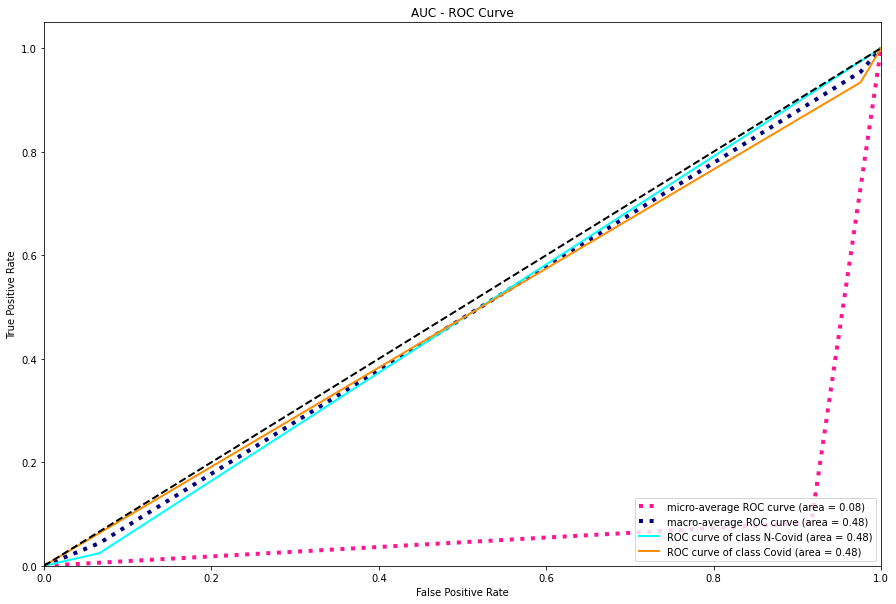

None

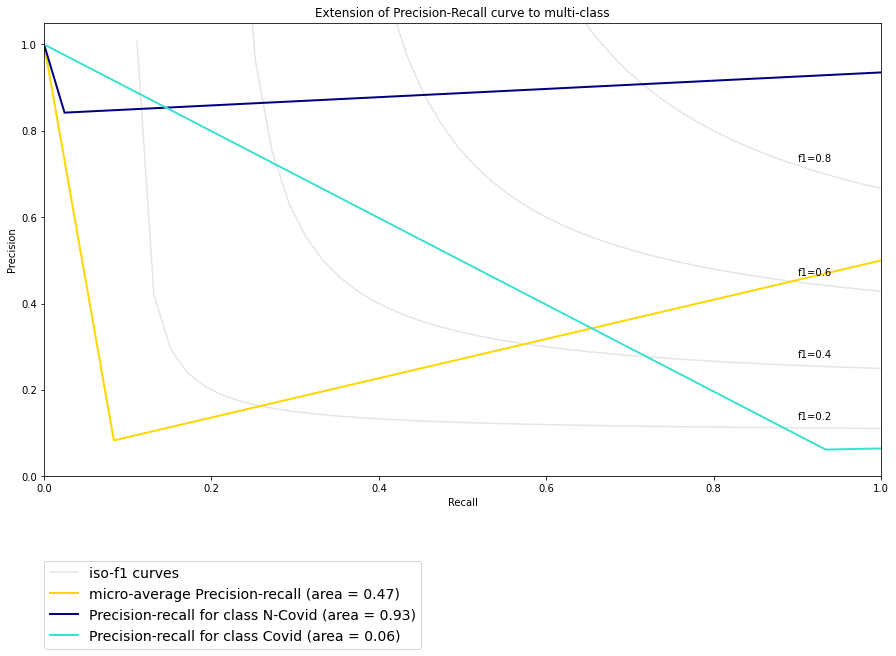

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.05     0.48     0.93       0.84    0.02         0.93      0.08
1    Covid  0.12     0.48     0.06       0.06    0.93         0.02      0.08
2    Média  0.08     0.48     0.50       0.45    0.48         0.48      0.08
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                969       
_________________________________________________________________
dense_1 (Dense)              (None, 88)                4576      
_________________________________________________________________
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_3 (Dense)    

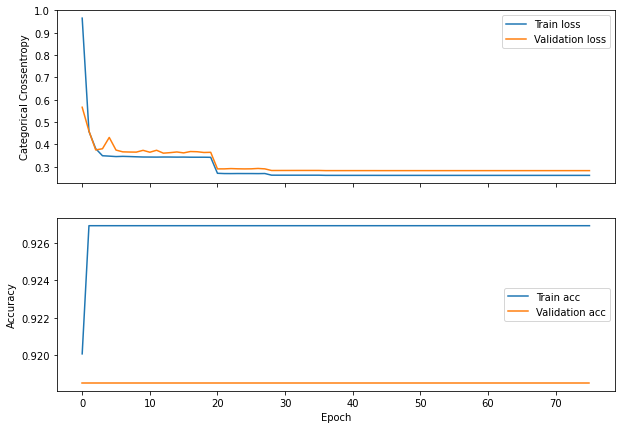

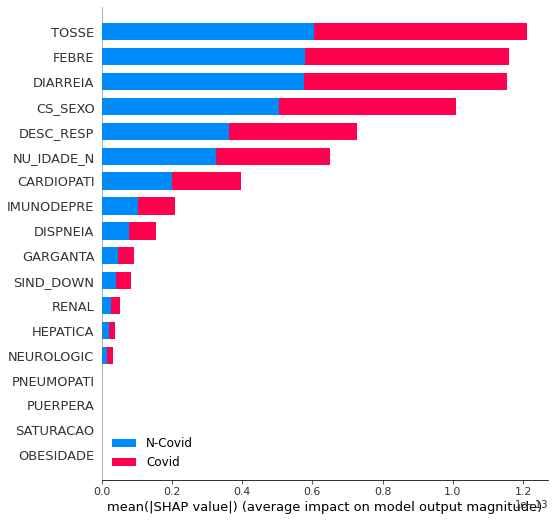

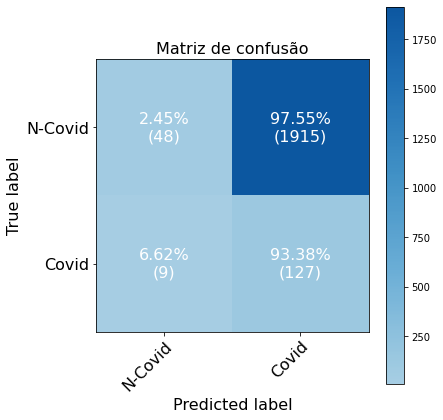

None

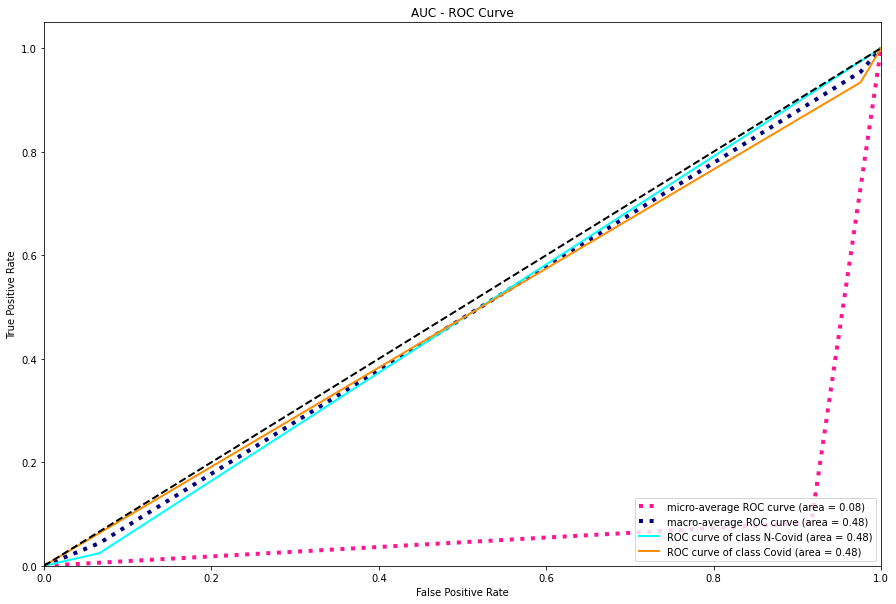

None

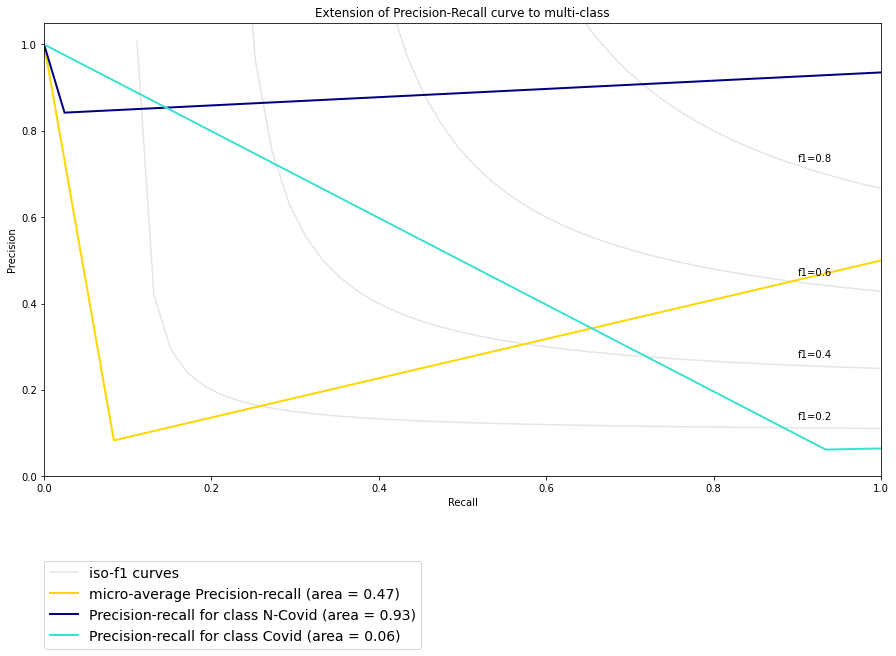

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.05     0.48     0.93       0.84    0.02         0.93      0.08
1    Covid  0.12     0.48     0.06       0.06    0.93         0.02      0.08
2    Média  0.08     0.48     0.50       0.45    0.48         0.48      0.08
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                969       
_________________________________________________________________
dense_1 (Dense)              (None, 88)                4576      
_________________________________________________________________
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_3 (Dense)    

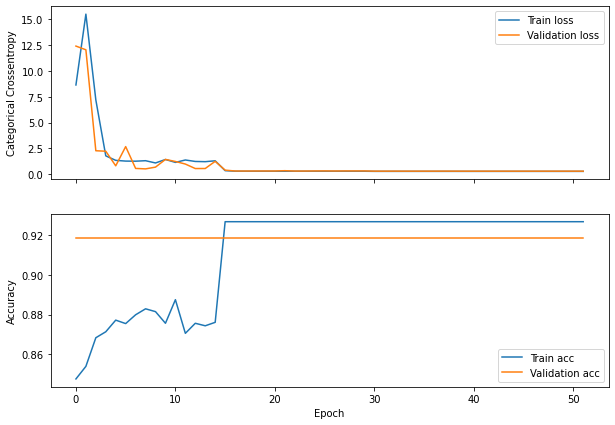

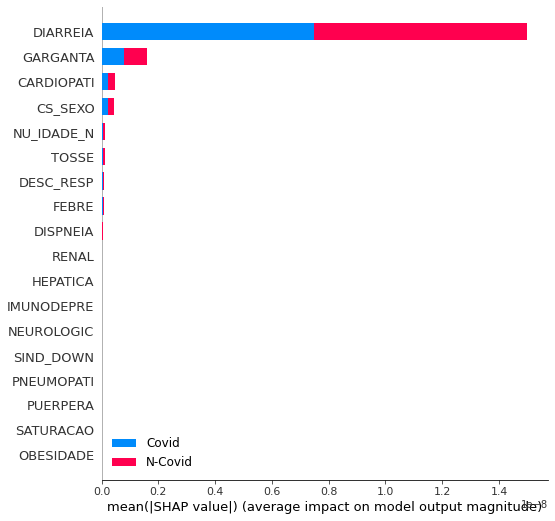

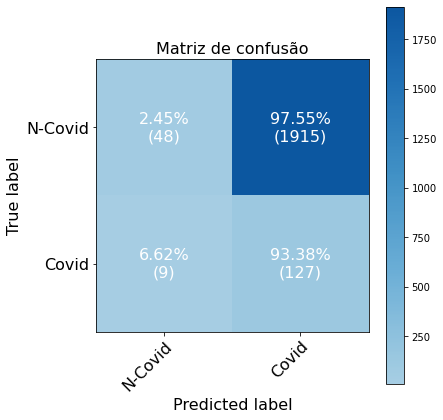

None

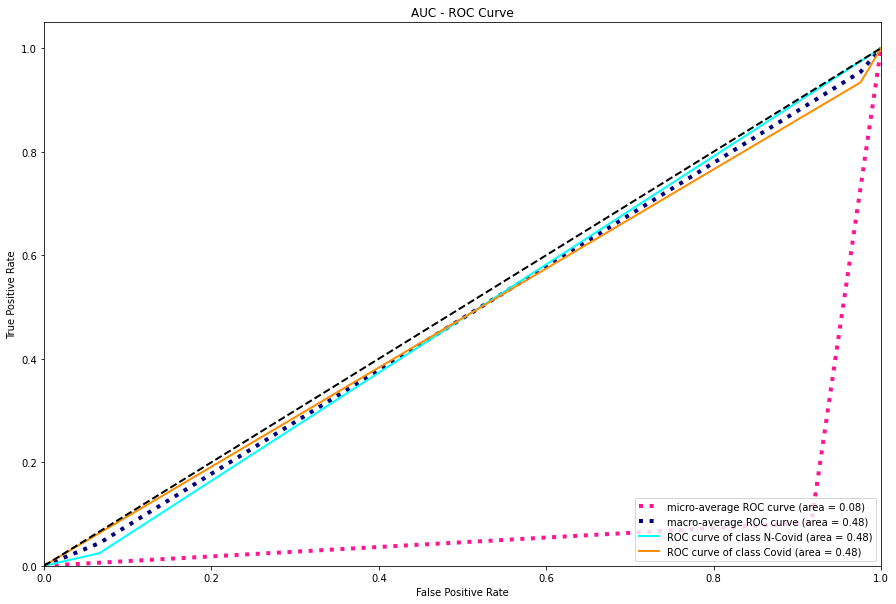

None

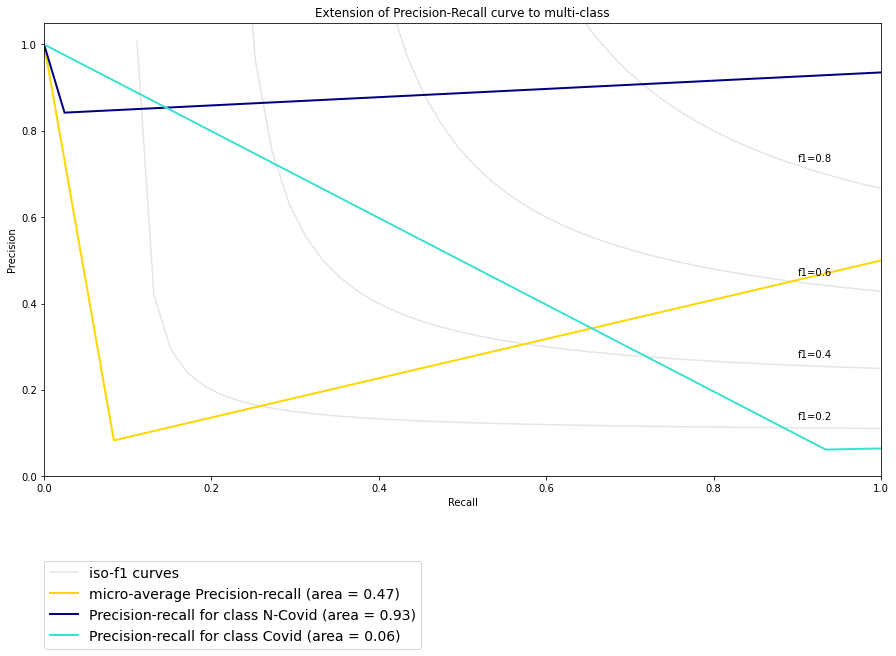

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.05     0.48     0.93       0.84    0.02         0.93      0.08
1    Covid  0.12     0.48     0.06       0.06    0.93         0.02      0.08
2    Média  0.08     0.48     0.50       0.45    0.48         0.48      0.08
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                969       
_________________________________________________________________
dense_1 (Dense)              (None, 88)                4576      
_________________________________________________________________
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_3 (Dense)    

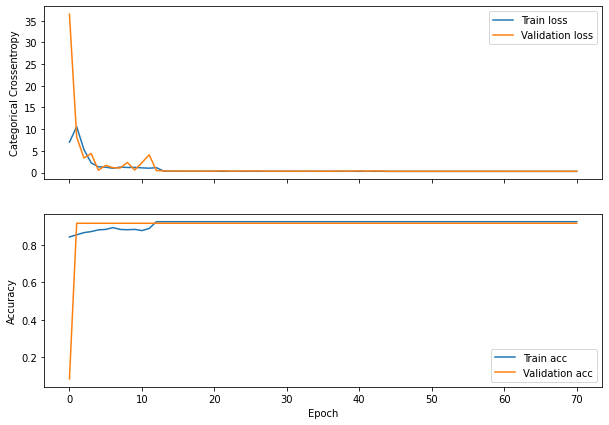

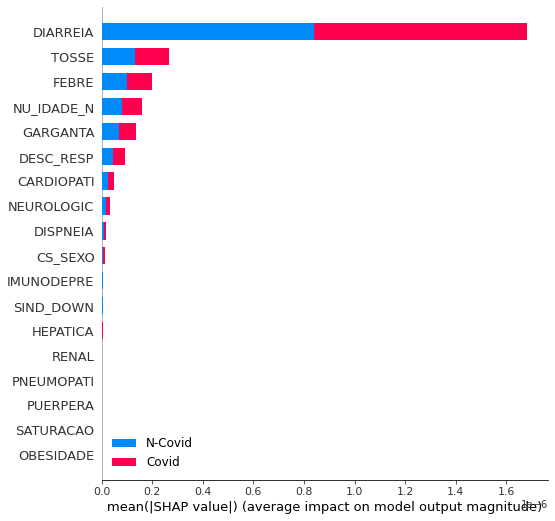

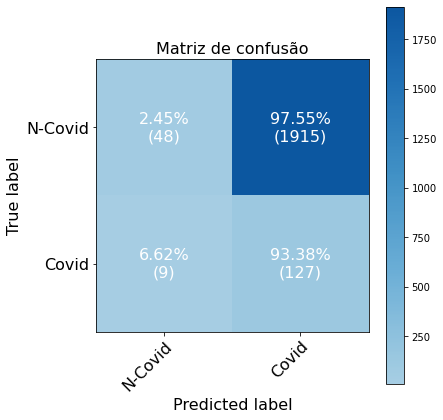

None

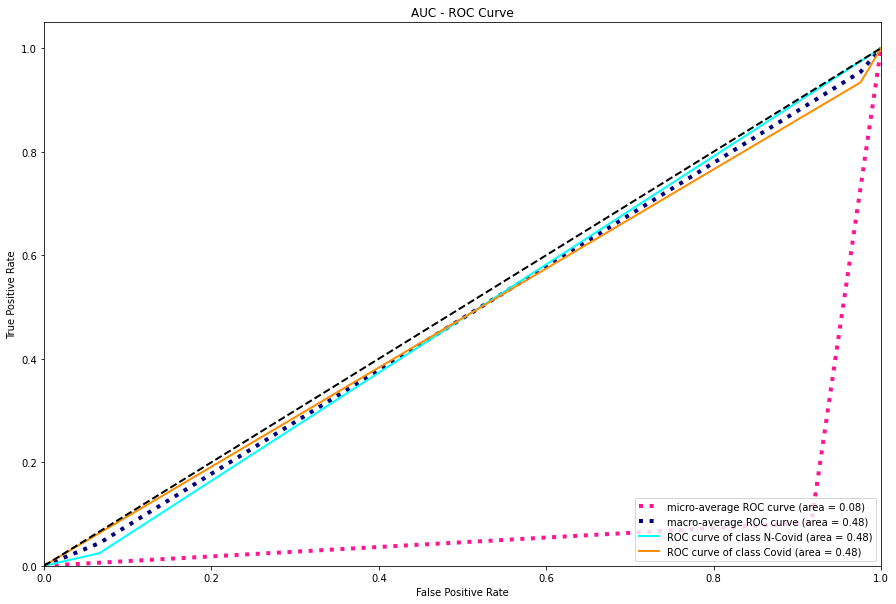

None

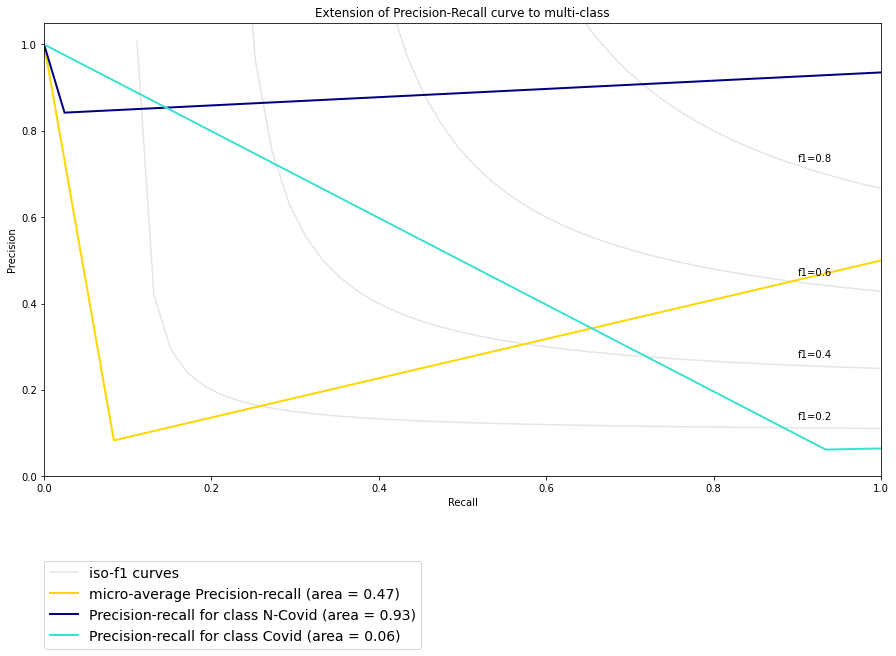

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.05     0.48     0.93       0.84    0.02         0.93      0.08
1    Covid  0.12     0.48     0.06       0.06    0.93         0.02      0.08
2    Média  0.08     0.48     0.50       0.45    0.48         0.48      0.08
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                969       
_________________________________________________________________
dense_1 (Dense)              (None, 88)                4576      
_________________________________________________________________
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_3 (Dense)    

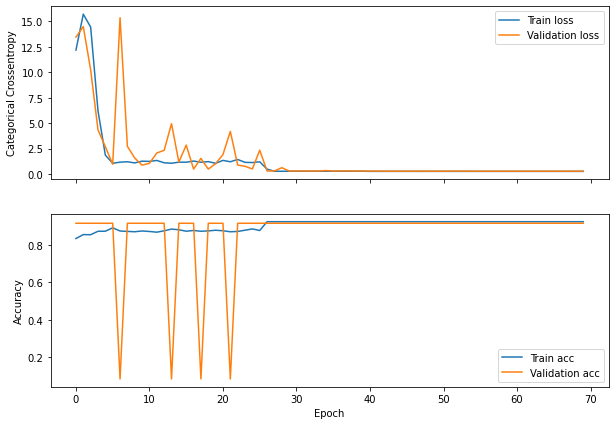

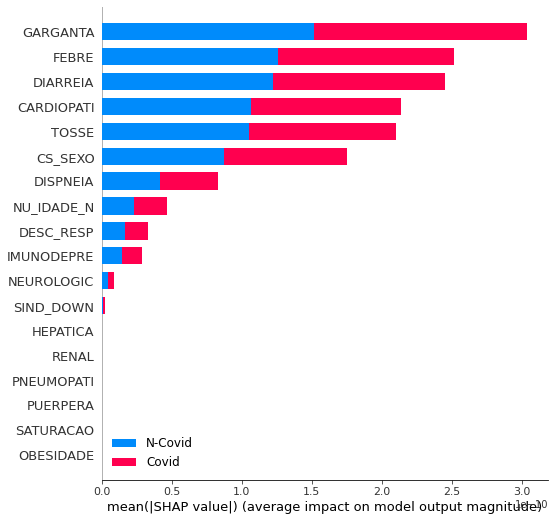

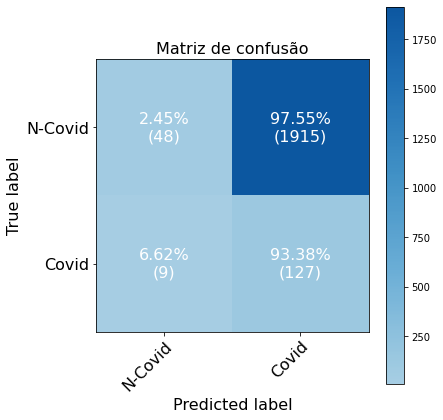

None

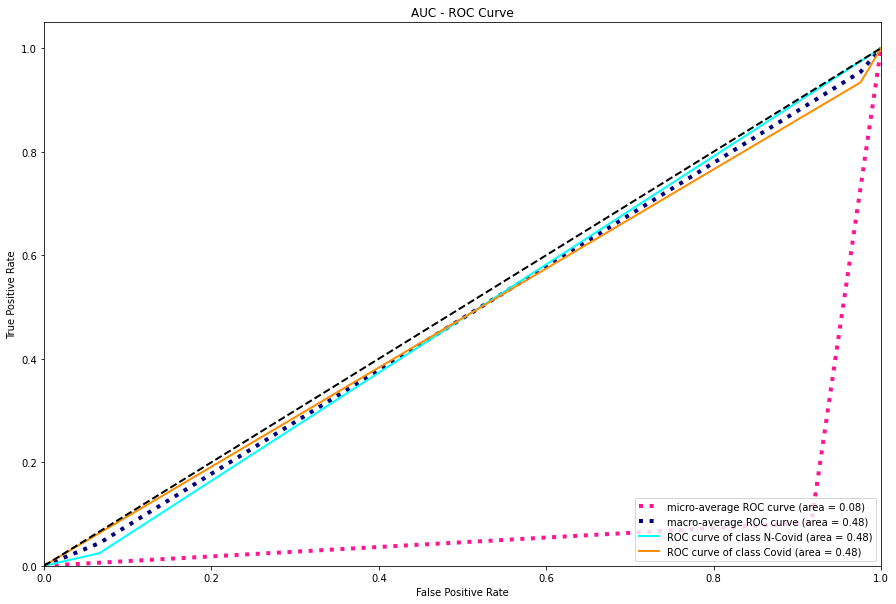

None

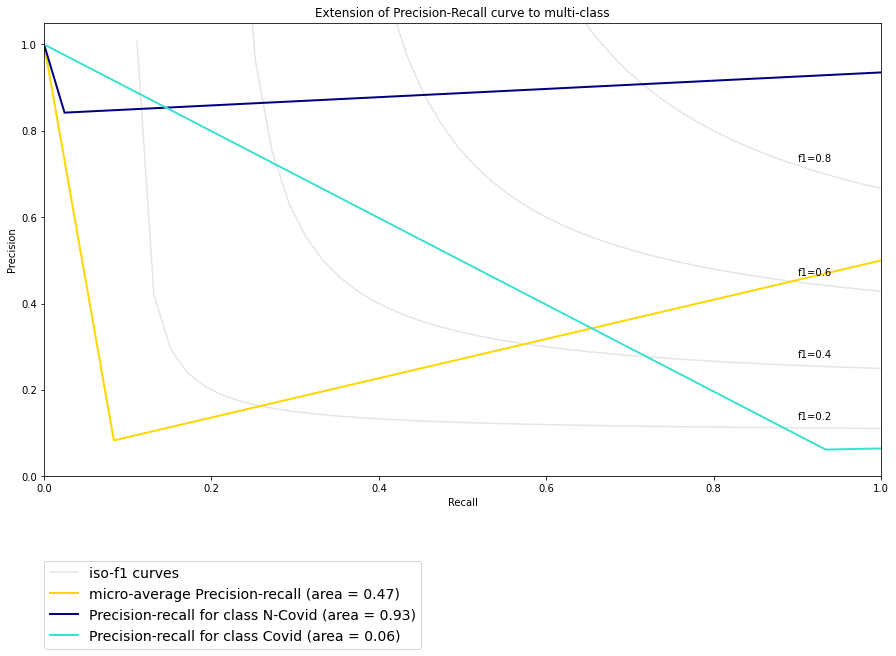

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.05     0.48     0.93       0.84    0.02         0.93      0.08
1    Covid  0.12     0.48     0.06       0.06    0.93         0.02      0.08
2    Média  0.08     0.48     0.50       0.45    0.48         0.48      0.08
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                969       
_________________________________________________________________
dense_1 (Dense)              (None, 88)                4576      
_________________________________________________________________
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_3 (Dense)    

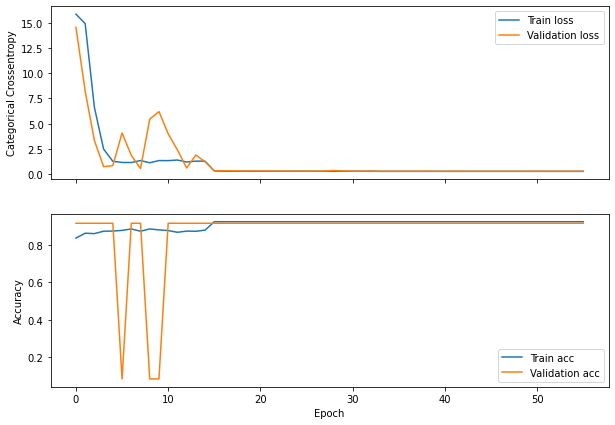

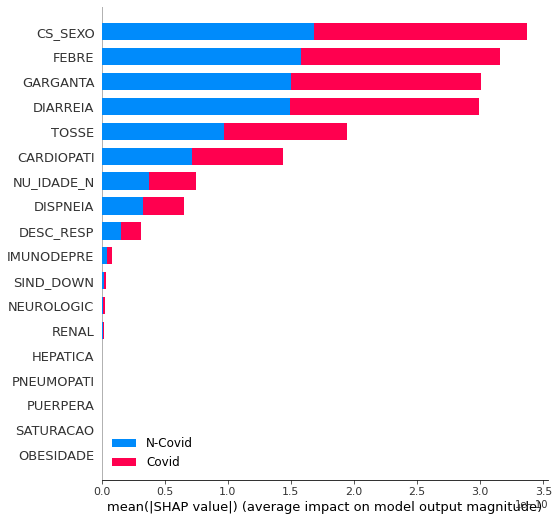

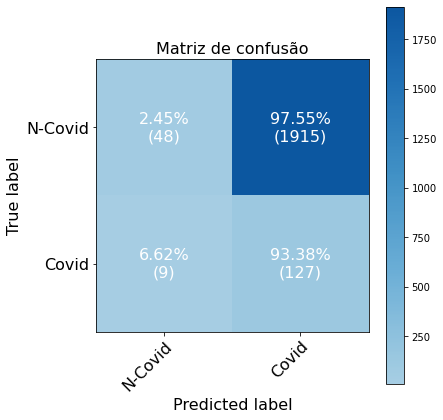

None

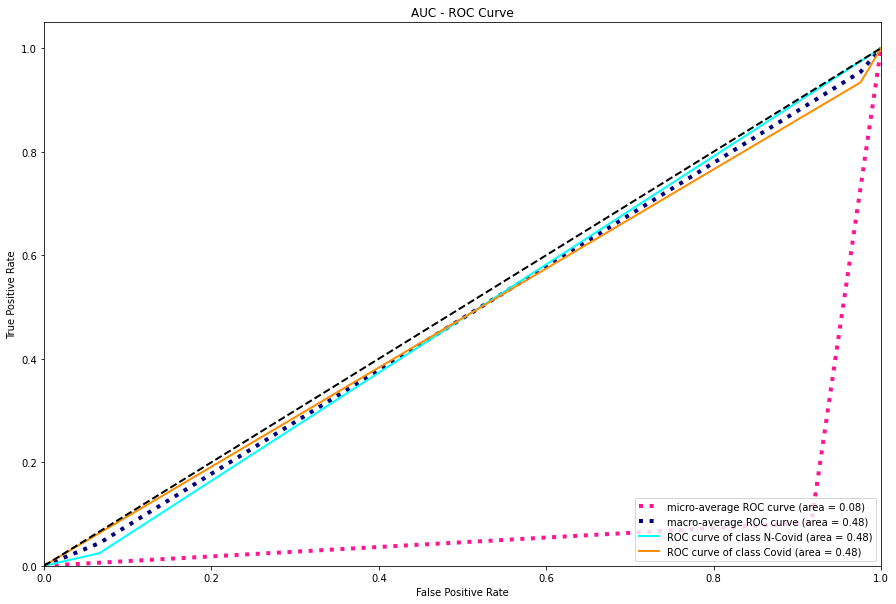

None

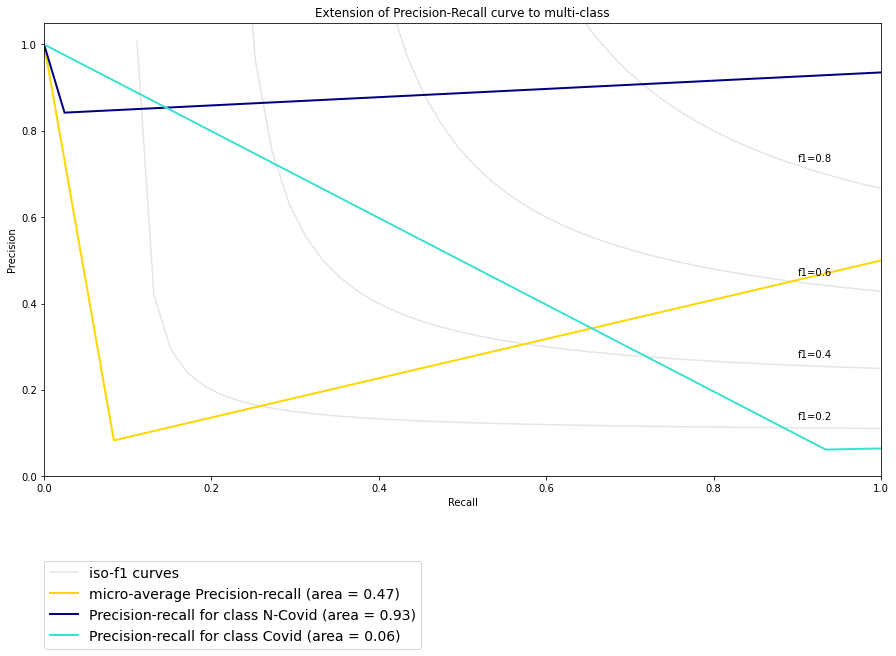

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.05     0.48     0.93       0.84    0.02         0.93      0.08
1    Covid  0.12     0.48     0.06       0.06    0.93         0.02      0.08
2    Média  0.08     0.48     0.50       0.45    0.48         0.48      0.08


In [332]:
all_metrics = []

for ignored in range(1,len(model.layers)+1):
    tf.keras.backend.clear_session()
    opt = tf.keras.optimizers.SGD(lr=0.41001897516490954)
    auc = tf.keras.metrics.AUC()

    out = f'{path}/ig{ignored}'
    sync_path(out)

    monitor = 'val_loss'
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{out}/best_model.h5', monitor=monitor, save_best_only=True, mode='min'),
        tf.keras.callbacks.TensorBoard(log_dir=f'{out}/logs'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=7, min_delta=1e-4, mode='min'),
    ]

    transfer_model = tf.keras.models.clone_model(model)
    transfer_model.set_weights(model.get_weights())
    for layer in transfer_model.layers[:-ignored]:
        layer.trainable = False
    
    # Compile
    transfer_model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['acc', precision_m, recall_m, f1_m, auc]
    )
    transfer_model.summary()

    # train the neural network
    H = transfer_model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=500,
        batch_size=17, # 179
        callbacks=callbacks
    )

    # History
    with open(f'{out}/history_best_model.pkl', 'wb') as f:
        pickle.dump(H.history, f)
    show_history(f'{out}/history_best_model.pkl')
    
    lbs = ['N-Covid', 'Covid']

    # SHAP
    background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
    e = shap.GradientExplainer(transfer_model, background)
    samples = x_test[np.random.choice(x_test.shape[0], 1000, replace=False)]
    shap_values = e.shap_values(samples)
    shap.summary_plot(shap_values, samples, feature_names=x_cols, show=False, class_names=lbs)
    plt.savefig(f'{out}/shap_summary.png')

    # evaluate the model
    y_pred = model.predict(x_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    pai.plot_graphics(y_true, y_pred, class_names=lbs, save_path=out)
    metrics = pai.get_metrics(y_true, y_pred, class_names=lbs, save_path=out)
    print(metrics)
    all_metrics.append(metrics)

Média e desvio padrão dos k-folds

In [333]:
aux = []
for target in all_metrics[0].index[:-1]:
    m = [
        metrics.loc[target].rename(
            f"{metrics.loc[target, 'Classes']} -{i+1}l"
        ).drop('Classes')
        for i, metrics in enumerate(all_metrics)
    ]

    df = pd.DataFrame(m)
    df.loc['Avg'] = df.iloc[:5].apply(lambda x: x.mean()).round(2)
    df.loc['Std'] = df.iloc[:5].apply(lambda x: x.std()).round(2)
    display(df)
    df.to_csv(f'{path}/{all_metrics[0].loc[target].Classes}_metrics.csv')

,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
N-Covid -1l,0.05,0.48,0.93,0.84,0.02,0.93,0.08
N-Covid -2l,0.05,0.48,0.93,0.84,0.02,0.93,0.08
N-Covid -3l,0.05,0.48,0.93,0.84,0.02,0.93,0.08
N-Covid -4l,0.05,0.48,0.93,0.84,0.02,0.93,0.08
N-Covid -5l,0.05,0.48,0.93,0.84,0.02,0.93,0.08
N-Covid -6l,0.05,0.48,0.93,0.84,0.02,0.93,0.08
Avg,0.05,0.48,0.93,0.84,0.02,0.93,0.08
Std,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
Covid -1l,0.12,0.48,0.06,0.06,0.93,0.02,0.08
Covid -2l,0.12,0.48,0.06,0.06,0.93,0.02,0.08
Covid -3l,0.12,0.48,0.06,0.06,0.93,0.02,0.08
Covid -4l,0.12,0.48,0.06,0.06,0.93,0.02,0.08
Covid -5l,0.12,0.48,0.06,0.06,0.93,0.02,0.08
Covid -6l,0.12,0.48,0.06,0.06,0.93,0.02,0.08
Avg,0.12,0.48,0.06,0.06,0.93,0.02,0.08
Std,0.00,0.00,0.00,0.00,0.00,0.00,0.00
